# Model Selection COVID-19 Supervised ML 

### Library Imports

In [118]:
# General Imports
import pandas as pd
import os
import numpy as np
from tabulate import tabulate

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


# Model Evaluation
from sklearn.metrics import accuracy_score, roc_curve, auc, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


# Graphing 
import matplotlib.pyplot as plt
import seaborn as sns

# dataset balancing
from imblearn.over_sampling import RandomOverSampler

# Explainable ML w/ SHAP
import shap

### Inspect Data

In [3]:
# get file path
fp = '/Users/Carancho/Documents/School/UF/PhD/publications/data/covid_subset_final.csv'

In [4]:
# import and create df for data
df = pd.read_csv(fp, index_col=0)
df

,AGE,covid_result,sex,race_white,race_black,race_other,ethnic,hypertension,hyperlipidemia,type_2_diabetes_no_complication,...,Respiratory_rate,Body_height,Body_weight,ACE,ARB,HCQ,STEROID,race,nutrition_deficiency,discharged_home
3,71,1,0.0,0,1,0,0.0,1,1,1,...,19.0,167.6399,79.80384,1.0,0.0,0.0,0.0,2.0,1,0
4,29,1,0.0,0,1,0,0.0,0,0,0,...,35.0,172.7200,129.30200,0.0,0.0,0.0,1.0,2.0,0,1
7,56,1,0.0,0,1,0,0.0,1,1,1,...,18.0,172.7200,79.37860,0.0,1.0,0.0,0.0,2.0,1,1
9,41,1,0.0,0,1,0,0.0,0,0,0,...,16.0,160.0200,85.27529,0.0,0.0,0.0,0.0,2.0,0,1
10,56,1,0.0,0,1,0,0.0,1,0,1,...,15.0,160.0200,67.13161,0.0,1.0,0.0,1.0,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59614,40,1,0.0,0,1,0,0.0,1,0,0,...,16.0,162.5599,136.38940,0.0,0.0,0.0,0.0,2.0,0,1
59669,45,1,1.0,1,0,0,0.0,1,0,0,...,15.0,167.6399,74.84268,0.0,0.0,0.0,1.0,1.0,1,0
59684,63,1,1.0,1,0,0,0.0,1,1,1,...,13.0,180.2993,85.10519,0.0,0.0,0.0,0.0,1.0,1,1
59689,56,1,0.0,1,0,0,1.0,0,1,0,...,18.0,172.7200,86.18248,0.0,0.0,0.0,0.0,1.0,1,1


In [5]:
# descriptive stats for SEX
df.sex.value_counts().reset_index()
mean = df.groupby("sex").mean()
std = df.groupby("sex").std()

print(f"Mean: {mean['AGE']}")
print(f"SD: {std['AGE']}")

Mean: sex
0.0    51.856250
1.0    54.346278
Name: AGE, dtype: float64
SD: sex
0.0    18.494036
1.0    18.481841
Name: AGE, dtype: float64


In [6]:
# Discharge Counts
print(df.discharged_home.value_counts().reset_index())

   index  discharged_home
0      1             1348
1      0              230


In [51]:
def generate_metrics_table(classifiers, X_train, y_train, X_test, y_test):
    table = []
    for clf in classifiers:
        print(f"{clf}")
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        brier = brier_score_loss(y_test, y_prob)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        table.append([clf.__class__.__name__, np.mean(scores), roc_auc, acc, specificity, recall, precision, f1, brier])
    headers = ['Classifier', 'CV AUC', 'Test AUC', 'Accuracy', 'Specificity', 'Recall', 'Precision', 'F1', 'Brier Score']
    
    print(tabulate(table, headers=headers))
    return tabulate(table, headers=headers)


## No Oversampling of Minority Class

In [27]:
# use non oversampled data first to make comparisons
xtrain, xtest, ytrain, ytest = train_test_split(df.iloc[:,0:-1], 
                                                df.iloc[:,-1],
                                                train_size=0.8, 
                                                random_state=42)

In [111]:
classifiers = [
    LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(),       
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    SVC(probability=True, kernel='linear')
]

Mean AUC: 0.7264201899397752
Std AUC: 0.03479779376881268
Mean AUC: 0.580262787612058
Std AUC: 0.018721632453745723
Mean AUC: 0.5997811059907834
Std AUC: 0.032800444721866426
Mean AUC: 0.7467179918562408
Std AUC: 0.03438193633514089
Mean AUC: 0.7061906861510037
Std AUC: 0.050711048603375754
Mean AUC: 0.6939478437731126
Std AUC: 0.048353574337976137


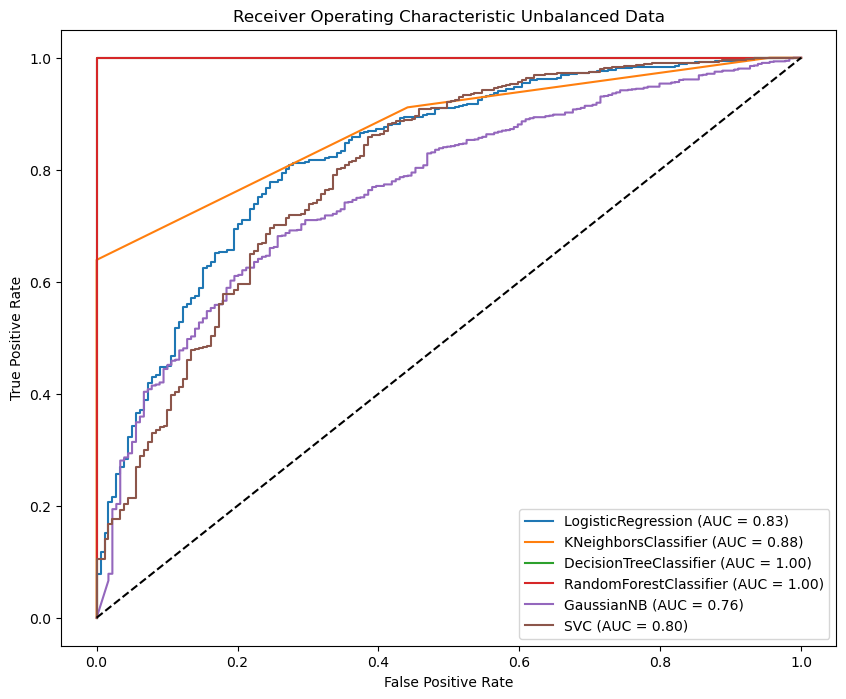

In [112]:
# number of folds for cross-validation
cv = 5  
plt.figure(figsize=(10, 8))

for clf in classifiers:
    scores = cross_val_score(clf, xtrain, ytrain, cv=cv, scoring='roc_auc')
    mean_auc = scores.mean()
    std_auc = scores.std()
    print("Mean AUC:", mean_auc)
    print("Std AUC:", std_auc)

    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtrain)
    y_prob = clf.predict_proba(xtrain)[:, 1]
    fpr, tpr, _ = roc_curve(ytrain, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(ytrain, y_pred)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Unbalanced Data')
plt.legend(loc="lower right")
plt.savefig('roc_curve_unbalanced.png', dpi=1000, bbox_inches='tight')
plt.show()

### Calibrated AUCROC Graph

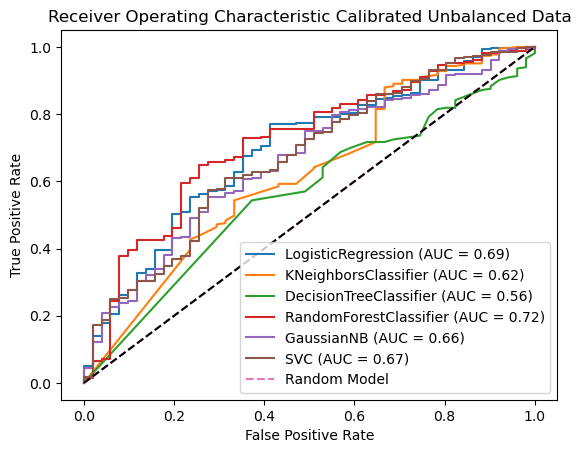

+-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------+
|             |   LogisticRegression |   KNeighborsClassifier |   DecisionTreeClassifier |   RandomForestClassifier |   GaussianNB |       SVC |
|-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------|
| AUC         |            0.693822  |               0.618461 |                 0.563374 |                0.715353  |     0.661709 | 0.670292  |
| Acc         |            0.851266  |               0.838608 |                 0.838608 |                0.835443  |     0.838608 | 0.841772  |
| Precision   |            0.851613  |               0.838608 |                 0.838608 |                0.842444  |     0.838608 | 0.84127   |
| Recall      |            0.996226  |               1        |                 1        |                0.988679  |     1       

In [119]:
# create empty lists to store results
metrics = {
    'AUC': [],
    'Acc': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'Specificity': [],
    'Brier Score': []
}


for clf in classifiers:
    # fit the model
    clf.fit(xtrain, ytrain)
    
    # calibrate the model
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(xtrain, ytrain)
    
    # make predictions on the test data
    y_pred = calibrated_clf.predict(xtest)
    y_prob = calibrated_clf.predict_proba(xtest)[:, 1]
    
    # calculate metrics
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    brier_score = brier_score_loss(ytest, y_prob)
    tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # organize metrics
    metrics['AUC'].append(roc_auc_score(ytest, y_prob))
    metrics['Acc'].append(accuracy_score(ytest, y_pred))
    metrics['Precision'].append(precision_score(ytest, y_pred))
    metrics['Recall'].append(recall_score(ytest, y_pred))
    metrics['F1'].append(f1_score(ytest, y_pred))
    metrics['Brier Score'].append(brier_score)
    metrics['Specificity'].append(specificity)
    
    # plot the ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

# plot the ROC curve for a random model
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Calibrated Unbalanced Data')
plt.legend(loc="lower right")
plt.savefig('calibrated_roc_curve_unbalanced.png', 
            dpi=1000, 
            bbox_inches='tight')
plt.show()

calibrated_unbalanced_metrics_df = pd.DataFrame.from_dict(metrics,
                                                          orient='index',
                                                          columns=[clf.__class__.__name__ for clf in classifiers])

print(tabulate(calibrated_unbalanced_metrics_df, 
               headers='keys', 
               tablefmt='psql'))

## Balance the data

In [63]:
# checking for balance in data
bal = df['discharged_home'].value_counts().reset_index()
bal

,index,discharged_home
0,1,1348
1,0,230


In [64]:
# over sampling minority class
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(df.iloc[:,0:-1], df.iloc[:,-1])


In [65]:
# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, 
                                                    test_size=0.2, random_state=42)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, random_state=42)

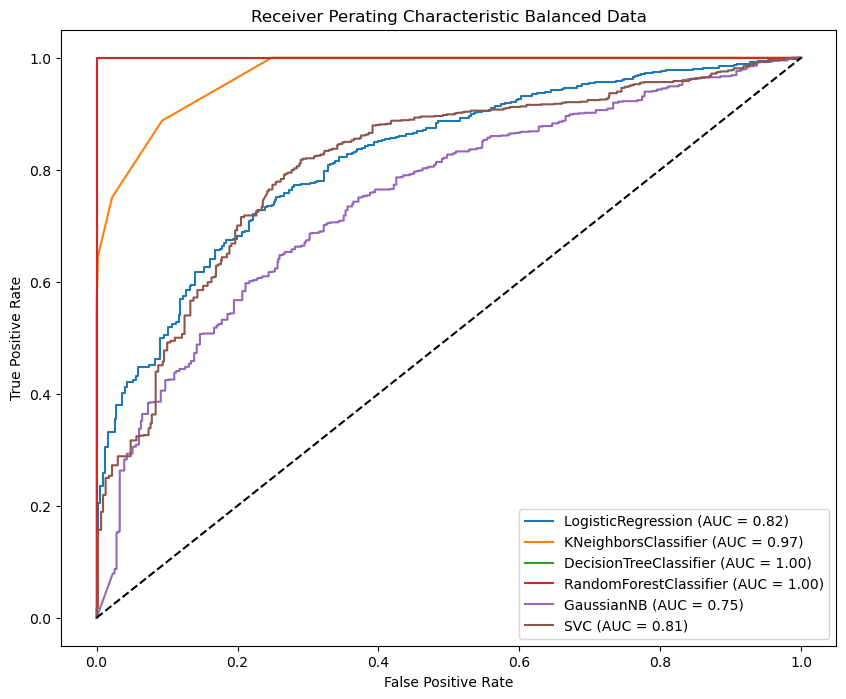

In [114]:
# number of folds for cross-validation
cv = 5  
plt.figure(figsize=(10, 8))

for clf in classifiers:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_auc = scores.mean()
    std_auc = scores.std()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_train, y_pred)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Perating Characteristic Balanced Data')
plt.legend(loc="lower right")
plt.savefig('roc_curve_balanced.png', dpi=1000, bbox_inches='tight')
plt.show()


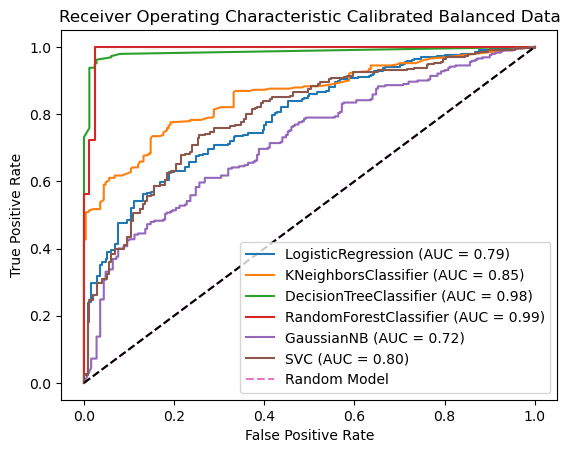

+-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+----------+
|             |   LogisticRegression |   KNeighborsClassifier |   DecisionTreeClassifier |   RandomForestClassifier |   GaussianNB |      SVC |
|-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+----------|
| AUC         |             0.78869  |               0.854993 |                0.98489   |                0.991434  |     0.719586 | 0.795766 |
| Acc         |             0.707407 |               0.77963  |                0.946296  |                0.983333  |     0.644444 | 0.735185 |
| Precision   |             0.73741  |               0.830116 |                0.988764  |                0.979522  |     0.676259 | 0.767273 |
| Recall      |             0.706897 |               0.741379 |                0.910345  |                0.989655  |     0.648276 | 0.7

In [121]:
# create empty lists to store results
metrics = {
    'AUC': [],
    'Acc': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'Specificity': [],
    'Brier Score': []
}


for clf in classifiers:
    clf.fit(X_train, y_train)
    
    # calibrate the model
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(X_train, y_train)
    
    # make predictions on the test data
    y_pred = calibrated_clf.predict(X_test)
    y_prob = calibrated_clf.predict_proba(X_test)[:, 1]
    
    # calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    brier_score = brier_score_loss(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    metrics['AUC'].append(roc_auc_score(y_test, y_prob))
    metrics['Acc'].append(acc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1'].append(f1)
    metrics['Brier Score'].append(brier_score)
    metrics['Specificity'].append(specificity)
    
    # plot the ROC curve
    #fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

# plot the ROC curve for a random model
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Calibrated Balanced Data')
plt.legend(loc="lower right")
plt.savefig('calibrated_roc_curve_balanced.png', 
            dpi=1000, 
            bbox_inches='tight')
plt.show()

calibrated_balanced_metrics_df = pd.DataFrame.from_dict(metrics,
                                                          orient='index',
                                                          columns=[clf.__class__.__name__ for clf in classifiers])

print(tabulate(calibrated_balanced_metrics_df, 
               headers='keys', 
               tablefmt='psql'))

## Calbiration Plots

### Unbalanced Calibration Plot

### Balanced Calibration Plot

## SHAP Analysis

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  0%|          | 0/100 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid

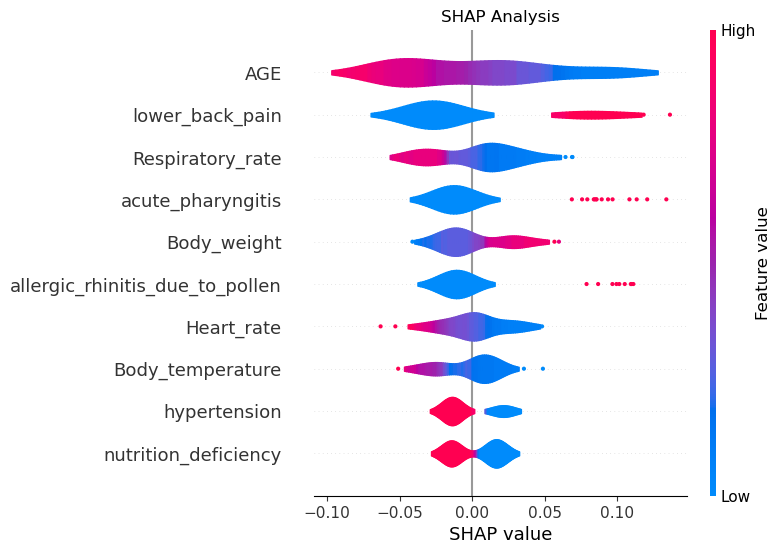

In [128]:
# Train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# calibrate the model
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(X_train.iloc[:100], y_train.iloc[:100])

# Create a SHAP explainer object using KernelExplainer
background = shap.sample(X_train.iloc[:100], 100)
explainer = shap.KernelExplainer(calibrated_clf.predict_proba, background)

# Generate SHAP values for the test data
shap_values = explainer.shap_values(X_test.iloc[:100])

# Create a beeswarm plot
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values[1], X_test.iloc[:100], 
                  plot_type='violin', show=False, 
                  sort=True, max_display=10)

plt.title('SHAP Analysis')
ax.set_xlabel('SHAP value')
plt.savefig('shap_analysis.png', dpi=1000, bbox_inches='tight')
plt.show()

